In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, cohen_kappa_score, precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn import metrics
from scipy.stats import norm
import os
import glob

def AUC_CI(auc, label, alpha = 0.05):
    label = np.array(label)#防止label不是array类型
    n1, n2 = np.sum(label == 1), np.sum(label == 0)
    q1 = auc / (2-auc)
    q2 = (2 * auc ** 2) / (1 + auc)
    se = np.sqrt((auc * (1 - auc) + (n1 - 1) * (q1 - auc ** 2) + (n2 -1) * (q2 - auc ** 2)) / (n1 * n2))
    confidence_level = 1 - alpha
    z_lower, z_upper = norm.interval(confidence_level)
    lowerb, upperb = auc + z_lower * se, auc + z_upper * se
    return (lowerb, upperb)

def Youden_index(fpr, tpr):
    youden_index  = tpr - fpr
    return youden_index

## ensemble evaluation


### Step 2. 计算方法1： 计算病人block预测概率均值

- 读取test block级别预测概率 pred.csv

- 读取根据val计算出的各个fold的最佳阈值 result.csv

！ 请检查测试集数据没有被打乱且每个病人均有12个block，否则需要修改


### block level

In [7]:
import os
exp_name_all = [f'block64_new_2023-03-08T21:35:22/', \
            f'block96_new_2023-03-09T15:40:03/', \
            f'block128_new_2023-03-10T14:09:58/', \
            f'block160_new_2023-03-10T23:36:42/']


for exp_name in exp_name_all:
    eval = 'acc'
    path = glob.glob(os.path.join(f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/{exp_name}', f'test_best{eval}_*'))[0]

    csv_path = glob.glob(os.path.join(path, 'test_block_pred.csv'))[0]
    print(path, csv_path)
    df = pd.read_csv(csv_path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    save_path = path
    if not os.path.exists(save_path):
        os.makedirs(save_path)


    avg_pred = np.mean(pred, axis=1)

    bi_pred = np.zeros_like(avg_pred)
    bi_pred[avg_pred > 0.5] = 1

    acc = accuracy_score(label, bi_pred)
    f1 = f1_score(label, bi_pred, zero_division=1)
    pre = precision_score(label, bi_pred, zero_division=1)
    rec = recall_score(label, bi_pred, zero_division=1)
    confuse = confusion_matrix(label, bi_pred, labels=[1,0])
    spc = confuse[1, 1]/(confuse[1, 0] + confuse[1, 1])

    auc = roc_auc_score(label, avg_pred)
    

    # kappa
    total_num = confuse[0, 0] + confuse[1, 1] + confuse[0, 1] + confuse[1, 0]

    p0 = (confuse[0, 0] + confuse[1, 1]) / total_num
    pe = ((confuse[0, 0] + confuse[1, 0]) * (confuse[0, 0] + confuse[0, 1]) + (confuse[0, 1] + confuse[1, 1]) * (confuse[1, 0] + confuse[1, 1])) / (total_num * total_num)
    kappa = (p0 - pe) / (1 - pe)
    print(kappa)
    # kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

    tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
    ci95_upper = kappa + tmp
    ci95_lower = kappa - tmp

    u = kappa / (np.sqrt(p0 / total_num))

    print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')

    f = open(os.path.join(save_path, 'resemble_block.txt'),"a") 
    f.write(f'auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
    f.write(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
    f.close()


/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2024-02-03T22:54:04 /mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2024-02-03T22:54:04/test_block_pred.csv
0.7775161859917599
auc : 0.9215897817460318, acc : 0.890625, rec : 0.8779761904761905, spc : 0.9083333333333333
/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2024-02-03T22:55:49 /mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2024-02-03T22:55:49/test_block_pred.csv
0.8183976261127597
auc : 0.9319444444444444, acc : 0.9114583333333334, rec : 0.9166666666666666, spc : 0.9041666666666667
/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2024-02-03T22:57:35 /mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block128_new_2023-03-1

### patient level

In [8]:
import os
exp_name_all = [f'block64_new_2023-03-08T21:35:22/', \
            f'block96_new_2023-03-09T15:40:03/', \
            f'block128_new_2023-03-10T14:09:58/', \
            f'block160_new_2023-03-10T23:36:42/']


for exp_name in exp_name_all:
    eval = 'acc'
    
    path = glob.glob(os.path.join(f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/{exp_name}', f'test_best{eval}_*'))[0]
        
    csv_path = glob.glob(os.path.join(path, 'test_block_pred.csv'))[0]
    print(path, csv_path)
    df = pd.read_csv(csv_path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    save_path = path
    if not os.path.exists(save_path):
        os.makedirs(save_path)


    given_thresh = 0.5
    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []
    patient_name_all = []
    # f = open(f"{save_path}/resemble_patient_pred.txt","a") 
    # f.write(f'name, label, pred\r\n')
    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            # patient_name_all.append(patient_name)
            patient_label_all.append(label[i])
        
            # print(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)
                
    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    bi_patient_avg_pred_all = np.zeros_like(patient_avg_pred_all)
    bi_patient_avg_pred_all[patient_avg_pred_all > given_thresh] = 1

    acc = accuracy_score(patient_label_all, bi_patient_avg_pred_all)
    f1 = f1_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
    pre = precision_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
    rec = recall_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
    confuse = confusion_matrix(patient_label_all, bi_patient_avg_pred_all, labels=[1,0])
    spc = confuse[1, 1]/(confuse[1, 0] + confuse[1, 1])

    auc = roc_auc_score(patient_label_all, patient_avg_pred_all)
    (low, high) = AUC_CI(auc, patient_label_all, alpha=0.1)
    print(low, high)

    fpr = 1 - spc
    tpr = rec
        
    youden_index  = tpr - fpr

    # kappa
    total_num = confuse[0, 0] + confuse[1, 1] + confuse[0, 1] + confuse[1, 0]

    p0 = (confuse[0, 0] + confuse[1, 1]) / total_num
    pe = ((confuse[0, 0] + confuse[1, 0]) * (confuse[0, 0] + confuse[0, 1]) + (confuse[0, 1] + confuse[1, 1]) * (confuse[1, 0] + confuse[1, 1])) / (total_num * total_num)
    kappa = (p0 - pe) / (1 - pe)
    # print(kappa)
    # kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

    tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
    ci95_upper = kappa + tmp
    ci95_lower = kappa - tmp

    u = kappa / (np.sqrt(p0 / total_num))

    print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')
    print(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}')

    f = open(os.path.join(save_path, 'resemble_patient.txt'),"a") 
    f.write(f'auc, auc95, youden_idx, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
    f.write(f'{auc}, {[low, high]}, {youden_index}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
    f.close()

/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2024-02-03T22:54:04 /mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2024-02-03T22:54:04/test_block_pred.csv
0.7877897869949728 0.9550673558621701
auc : 0.8714285714285714, acc : 0.625, rec : 0.39285714285714285, spc : 0.95
0.8714285714285714, 0.625, 0.9166666666666666, 0.39285714285714285, 0.95, 11, 17, 1, 19, 0.3076923076923077, 0.625, 0.4583333333333333, [-0.05753212863265794, 0.6729167440172734], 2.6964802831023564
/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2024-02-03T22:55:49 /mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2024-02-03T22:55:49/test_block_pred.csv
0.7901641793629288 0.9562643920656425
auc : 0.8732142857142857, acc : 0.6458333333333334, rec : 0.42857142857142855, spc : 0.95
0.8732

- find optimal thresh 

[0.58333333 0.59574468 0.60869565 0.62222222 0.61363636 0.62790698
 0.61904762 0.63414634 0.65       0.66666667 0.68421053 0.7027027
 0.72222222 0.74285714 0.76470588 0.78787879 0.8125     0.80645161
 0.83333333 0.86206897 0.89285714 0.88888889 0.92307692 0.92
 0.91666667 0.91304348 0.90909091 0.9047619  0.95       0.94736842
 0.94444444 0.94117647 0.9375     0.93333333 0.92857143 0.92307692
 0.91666667 0.90909091 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
[1.         1.         1.         1.         0.96428571 0.96428571
 0.92857143 0.92857143 0.92857143 0.92857143 0.92857143 0.92857143
 0.92857143 0.92857143 0.92857143 0.92857143 0.92857143 0.89285714
 0.89285714 0.89285714 0.89285714 0.85714286 0.85714286 0.82142857
 0.78571429 0.75       0.71428571 0.67857143 0.67857143 0.64285714
 0.60714286 0.57142857 0.53571429 0.5        0.46428571 0.42857143
 0.39285714 0.35714286 0.35714286 0.32142857 0.28571429 0.25
 0.21428571

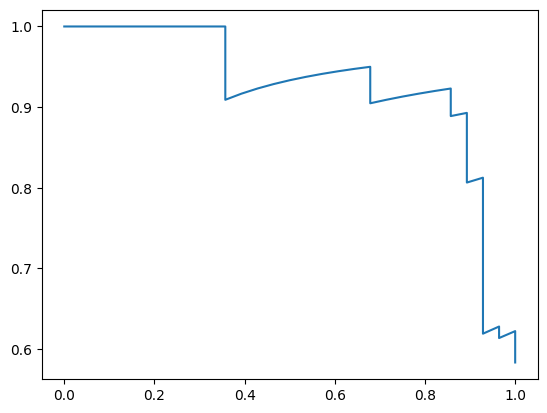

<Figure size 640x480 with 0 Axes>

In [7]:
precision, recall, thresholds = precision_recall_curve(patient_label_all, patient_avg_pred_all)
print(precision)
print(recall)
plt.figure(1)
plt.plot(recall, precision)
plt.show()
plt.savefig('{save_path}pr.png')

In [1]:
import os
exp_name_all = [f'block64_new_2023-03-08T21:35:22/', \
            f'block96_new_2023-03-09T15:40:03/', \
            f'block128_new_2023-03-10T14:09:58/', \
            f'block160_new_2023-03-10T23:36:42/']



for exp_name in exp_name_all:
    eval = 'acc'
    
    path = glob.glob(os.path.join(f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/{exp_name}', f'test_best{eval}_*'))[0]
        
    csv_path = glob.glob(os.path.join(path, 'test_block_pred.csv'))[0]
    print(path, csv_path)
    df = pd.read_csv(csv_path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    save_path = path
    if not os.path.exists(save_path):
        os.makedirs(save_path)


    given_thresh = 0.5
    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []

    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            patient_label_all.append(label[i])
            # print(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)

    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    precision, recall, thresholds = precision_recall_curve(patient_label_all, patient_avg_pred_all)
    fpr, tpr, thrsh = roc_curve(patient_label_all, patient_avg_pred_all)
    # youden_idx = Youden_index(patient_label_all, patient_avg_pred_all)

    # print(thresholds.shape, youden_idx.shape, thrsh.shape)

    f = open(os.path.join(save_path, 'resemble_patient_optthresh.txt'),"a") 
    f.write(f'thresh, auc, auc95ci, jouden_idx, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')

    for i in range(thresholds.shape[0]):
        try_thresh = thresholds[i]

        opt_bi_pred = patient_avg_pred_all.copy()
        opt_bi_pred[patient_avg_pred_all > try_thresh] = 1
        opt_bi_pred[patient_avg_pred_all <= try_thresh] = 0

        opt_acc = accuracy_score(patient_label_all, opt_bi_pred)
        opt_f1 = f1_score(patient_label_all, opt_bi_pred, zero_division=1)
        opt_pre = precision_score(patient_label_all, opt_bi_pred, zero_division=1)
        opt_rec = recall_score(patient_label_all, opt_bi_pred, zero_division=1)
        opt_confuse = confusion_matrix(patient_label_all, opt_bi_pred, labels=[1,0])
        opt_spc = opt_confuse[1, 1]/(opt_confuse[1, 0] + opt_confuse[1, 1])
        
        auc = roc_auc_score(patient_label_all, patient_avg_pred_all)
        (low, high) = AUC_CI(auc, patient_label_all, alpha=0.1)
        print(low, high)

        fpr = 1 - opt_spc
        tpr = opt_rec
        
        jouden_idx = Youden_index(fpr, tpr)


        # kappa
        total_num = opt_confuse[0, 0] + opt_confuse[1, 1] + opt_confuse[0, 1] + opt_confuse[1, 0]

        p0 = (opt_confuse[0, 0] + opt_confuse[1, 1]) / total_num
        pe = ((opt_confuse[0, 0] + opt_confuse[1, 0]) * (opt_confuse[0, 0] + opt_confuse[0, 1]) + (opt_confuse[0, 1] + opt_confuse[1, 1]) * (opt_confuse[1, 0] + opt_confuse[1, 1])) / (total_num * total_num)
        kappa = (p0 - pe) / (1 - pe)
        # kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

        tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
        ci95_upper = kappa + tmp
        ci95_lower = kappa - tmp

        u = kappa / (np.sqrt(p0 / total_num))

        print(f'thresh : {try_thresh}, acc : {opt_acc}, rec : {opt_rec}, spc : {opt_spc}')
        f.write(f'{try_thresh}, {auc}, {[low,high]}, {jouden_idx}, {opt_acc}, {opt_pre}, {opt_rec}, {opt_spc}, {opt_confuse[0, 0]}, {opt_confuse[0, 1]}, {opt_confuse[1, 0]}, {opt_confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
    f.close()


NameError: name 'glob' is not defined

## visualization

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import auc, roc_curve
import numpy as np

# eval = 'acc'
exp1_path = f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2024-02-03T22:54:04'
exp2_path = f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2024-02-03T22:55:49'
exp3_path = f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2024-02-03T22:57:35'
exp4_path = f'/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/log/block160_new_2023-03-10T23:36:42/test_bestacc_2024-02-03T22:59:22'


block_size = [64, 96, 128, 160]
exps = [exp1_path, exp2_path, exp3_path, exp4_path]    
color = ['orange', 'blue', 'green', 'red']


#### block level

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


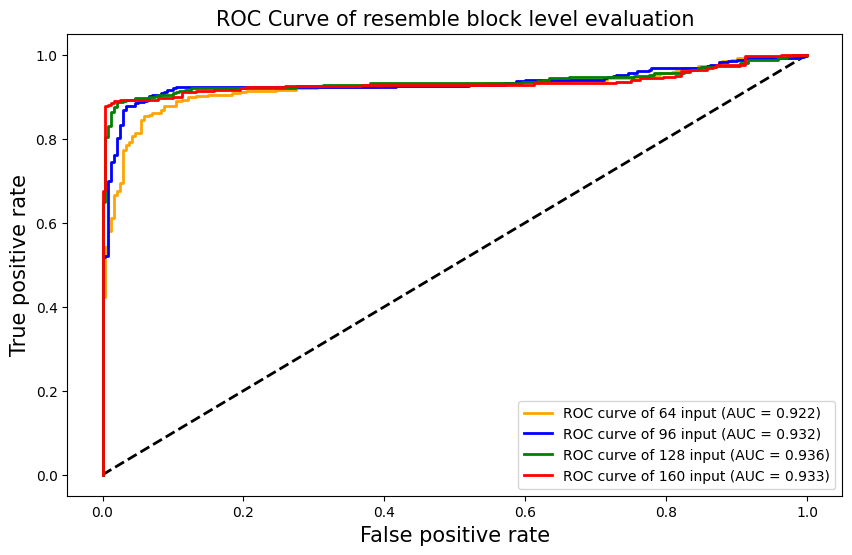

In [8]:
plt.figure(figsize=(10, 6))
plt.title(f'ROC Curve of resemble block level evaluation', fontdict={"family": "Times New Roman", "size": 15})
plt.plot([0, 1], [0, 1], lw=2, color='black', linestyle="--")
plt.xlabel('False positive rate', fontdict={"family": "Times New Roman", "size": 15})
plt.ylabel('True positive rate', fontdict={"family": "Times New Roman", "size": 15})

for i, path in enumerate(exps):
    block_pred_info = pd.read_csv(os.path.join(path, 'test_block_pred.csv'))

    

    label = block_pred_info['label']
    pred = np.stack((block_pred_info['pred0'], block_pred_info['pred1'], block_pred_info['pred2'], block_pred_info['pred3'], block_pred_info['pred4']), axis=1)
    avg_pred = np.mean(pred, axis=1)
    fpr, tpr, _ = roc_curve(label, avg_pred)
    plt.plot(fpr, tpr, lw=2, color=color[i], label=f'ROC curve of {block_size[i]} input (AUC = %0.3f)' % auc(fpr, tpr))

    plt.grid()  # 在图中添加网格

    plt.legend(loc="lower right") 
plt.savefig(os.path.join('/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/visual', f'5in1_ROC_blocklevel_resemble_{eval}.jpg'), dpi=256)


### patient level

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


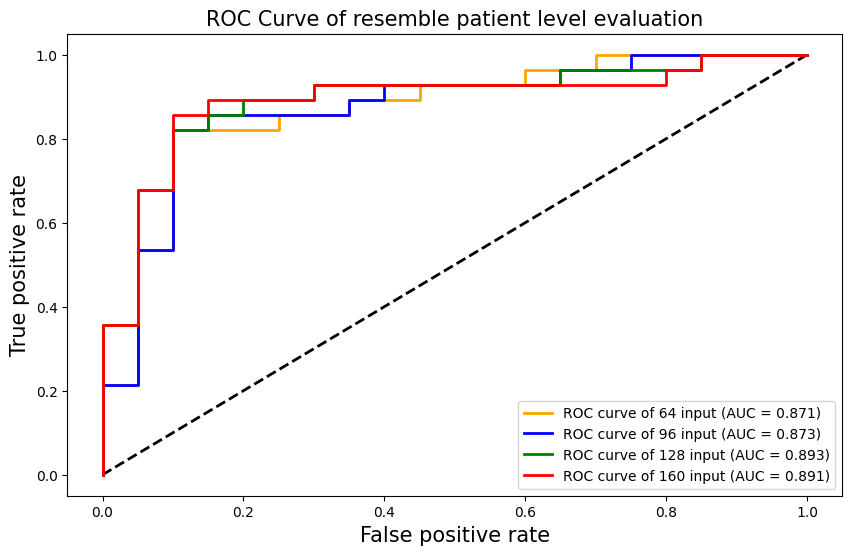

In [9]:
plt.figure(figsize=(10, 6))
plt.title(f'ROC Curve of resemble patient level evaluation', fontdict={"family": "Times New Roman", "size": 15})
plt.plot([0, 1], [0, 1], lw=2, color='black', linestyle="--")
plt.xlabel('False positive rate', fontdict={"family": "Times New Roman", "size": 15})
plt.ylabel('True positive rate', fontdict={"family": "Times New Roman", "size": 15})

for j, path in enumerate(exps):
    block_pred_info = pd.read_csv(os.path.join(path, 'test_block_pred.csv'))
    name = np.array(block_pred_info['name'])
    label = block_pred_info['label']
    pred = np.stack((block_pred_info['pred0'], block_pred_info['pred1'], block_pred_info['pred2'], block_pred_info['pred3'], block_pred_info['pred4']), axis=1)
    
    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []

    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            patient_label_all.append(label[i])
            # print(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)

    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    fpr, tpr, _ = roc_curve(patient_label_all, patient_avg_pred_all)
    plt.plot(fpr, tpr, lw=2, color=color[j], label=f'ROC curve of {block_size[j]} input (AUC = %0.3f)' % auc(fpr, tpr))

    plt.grid()  # 在图中添加网格

    plt.legend(loc="lower right") 
plt.savefig(os.path.join('/mnt/ExtData/workspace/pahsos/new_zhengzhou/classification/visual', f'5in1_ROC_patientlevel_resemble_{eval}.jpg'), dpi=256)


## check ori

In [10]:
import os
exp_name_all = [f'/mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block160_new_2023-03-10T23:36:42/']

thresh = []

for exp_name in exp_name_all:
    for eval in ('auc', 'acc'):
        if eval == 'auc':
            continue
        experiment_name = f'{exp_name}test_best{eval}'
        print(experiment_name)
        path = f'{experiment_name}/test_block_pred.csv'
        df = pd.read_csv(path)
        name = np.array(df['name'])
        label = np.array(df['label'])
        pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
        all = np.array(df)

        save_path = f'{experiment_name}'
        if not os.path.exists(save_path):
            os.makedirs(save_path)


        given_thresh = 0.5
        avg_pred = np.mean(pred, axis=1)
        patient_avg_pred_all = []
        patient_label_all = []
        patient_name_all = []
        # f = open(f"{save_path}/resemble_patient_pred.txt","a") 
        # f.write(f'name, label, pred\r\n')
        for i in range(len(name)):
            if i % 12 ==0:
                patient_name = name[i]
                # patient_name_all.append(patient_name)
                patient_label_all.append(label[i])
            
                # print(patient_name)
                patient_pred = 0
            else:
                assert name[i] == patient_name
                patient_pred += avg_pred[i]

                if i % 11 == 0:
                    patient_avg_pred = patient_pred / 12
                    patient_avg_pred_all.append(patient_avg_pred)
                    
        patient_label_all = np.array(patient_label_all)
        patient_avg_pred_all = np.array(patient_avg_pred_all)

        bi_patient_avg_pred_all = np.zeros_like(patient_avg_pred_all)
        bi_patient_avg_pred_all[patient_avg_pred_all > given_thresh] = 1

        acc = accuracy_score(patient_label_all, bi_patient_avg_pred_all)
        f1 = f1_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
        pre = precision_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
        rec = recall_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
        confuse = confusion_matrix(patient_label_all, bi_patient_avg_pred_all, labels=[1,0])
        spc = confuse[1, 1]/(confuse[1, 0] + confuse[1, 1])

        auc = roc_auc_score(patient_label_all, patient_avg_pred_all)
        (low, high) = AUC_CI(auc, patient_label_all, alpha=0.05)
        print(low, high)

        # kappa
        total_num = confuse[0, 0] + confuse[1, 1] + confuse[0, 1] + confuse[1, 0]

        p0 = (confuse[0, 0] + confuse[1, 1]) / total_num
        pe = ((confuse[0, 0] + confuse[1, 0]) * (confuse[0, 0] + confuse[0, 1]) + (confuse[0, 1] + confuse[1, 1]) * (confuse[1, 0] + confuse[1, 1])) / (total_num * total_num)
        kappa = (p0 - pe) / (1 - pe)
        # print(kappa)
        # kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

        tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
        ci95_upper = kappa + tmp
        ci95_lower = kappa - tmp

        u = kappa / (np.sqrt(p0 / total_num))

        print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')
        print(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}')

        # f = open(f"{save_path}/resemble_patient.txt","a") 
        # f.write(f'auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
        # f.write(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
        # f.close()

/mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc
0.6784477452353612 1.0284488064887767
auc : 0.853448275862069, acc : 0.8648648648648649, rec : 0.375, spc : 1.0
0.853448275862069, 0.8648648648648649, 1.0, 0.375, 1.0, 3, 5, 0, 29, 0.4846796657381617, 0.8648648648648649, 0.7377647918188459, [-0.3304847182807755, 1.2998440497570989], 3.1701625747068203
/mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc
0.8294695984140638 1.0584614360686948
auc : 0.9439655172413793, acc : 0.8918918918918919, rec : 0.5, spc : 1.0
0.9439655172413793, 0.8918918918918919, 1.0, 0.5, 1.0, 4, 4, 0, 29, 0.6105263157894736, 0.8918918918918919, 0.7224251278305333, [-0.3149859601815007, 1.5360385917604478], 3.9323226282202897
/mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc
0.7970914163563014 1.0563568595057677
auc : 0.9267241379310346, acc : 0.8918918918918919, rec : 0.5, spc : 1.0
0.